# Naive Classifier

In [766]:
#Add libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_curve, roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [767]:
#Get data
data = 'Data\stroke-data.csv'
df=pd.read_csv(data)

### Exploratory Data Analysis

In [768]:
# View dimensions of the dataset
df.shape

#Preview the dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [769]:
#View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [770]:
#Drop the unique ids
df =df.drop(['id'],axis=1)

In [771]:
#Find Categorical Variables
categorical =[var for var in df.columns if df[var].dtype == 'object']

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are:\n\n', categorical)

There are 5 categorical variables

The categorical variables are:

 ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [772]:
#view the categorical variables
df[categorical].head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [773]:
# Check missing values in categorical variables
df[categorical].isnull().sum()

gender            0
ever_married      0
work_type         0
Residence_type    0
smoking_status    0
dtype: int64

In [774]:
# View frequency counts of values in categorical variables
for var in categorical:
    print(df[var].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [775]:
# View frequency distribution of categorical variables
for var in categorical:
    print(df[var].value_counts()/np.float(len(df)))

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64
Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64
Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64
Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64
never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64


#### Explore smoking variables

In [776]:
# Check labels in smoke class
df.smoking_status.unique()

#Replace 'Unknown' values in workclass variable with NaN
df['smoking_status'].replace('Unknown', np.NaN, inplace=True)
#Again check the frequency distribution of values in smoking status variable
df.smoking_status.value_counts()

never smoked       1892
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [777]:
df[categorical].isnull().sum()

gender               0
ever_married         0
work_type            0
Residence_type       0
smoking_status    1544
dtype: int64

In [778]:
# Check for cardinality in categorical variables
for var in categorical:
    print(var, 'contains', len(df[var].unique()), 'labels')

gender contains 3 labels
ever_married contains 2 labels
work_type contains 5 labels
Residence_type contains 2 labels
smoking_status contains 4 labels


In [779]:
# Find numerical variables
numerical = [var for var in df.columns if df[var].dtype!='object']
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

There are 6 numerical variables

The numerical variables are : ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


In [780]:
#View the numerical variables
df[numerical].head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,NaN,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [781]:
#Check Missing values
df[numerical].isnull().sum()

age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
stroke                 0
dtype: int64

### Declaring Feature Vector and Spliting Train and Test

In [782]:
#View the numerical variables
df[numerical].head()

In [783]:
#Split data into separate training and test and test set

X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.3, random_state=0)

### Feature Engineering

In [784]:
# Check data types in X_train
X_train.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object

In [785]:
# Display categorical Variables
categorical=[col for col in X_train.columns if X_train[col].dtypes=='object']
categorical

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [786]:
# Display numerical Variables
numerical=[col for col in X_train.columns if X_train[col].dtypes!='object']
numerical

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [787]:
# Print percentage of missing value in the categorical variable
X_train[categorical].isnull().mean()

gender            0.000000
ever_married      0.000000
work_type         0.000000
Residence_type    0.000000
smoking_status    0.303327
dtype: float64

In [788]:
# Print percentage of missing value in the numerical variable
X_train[numerical].isnull().mean()

age                  0.000000
hypertension         0.000000
heart_disease        0.000000
avg_glucose_level    0.000000
bmi                  0.040257
dtype: float64

In [789]:
# Print categorical variables with missing data
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

smoking_status 0.30332681017612523


In [790]:
# Print numerical variables with missing data
for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

bmi 0.04025719876991893


In [791]:
# Input missing variables with most frequent value
for df2 in [X_train, X_test]:
    df2['smoking_status'].fillna(X_train['smoking_status'].mode()[0],inplace=True)
    df2['bmi'].fillna(X_train['bmi'].mode()[0],inplace=True)

#Check missing values in categorical variables in X train
X_train[categorical].isnull().sum()

gender            0
ever_married      0
work_type         0
Residence_type    0
smoking_status    0
dtype: int64

In [792]:
# Check missing values in categorical variables in X_test
X_test[categorical].isnull().sum()

gender            0
ever_married      0
work_type         0
Residence_type    0
smoking_status    0
dtype: int64

In [793]:
#Check missing values in numerical variables in X train
X_train[numerical].isnull().sum()

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
dtype: int64

In [794]:
#Check missing values in numerical variables in X test
X_test[numerical].isnull().sum()

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
dtype: int64

In [795]:
# Check missing values in X_train
X_train.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [796]:
# Check missing values in X_test
X_test.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [797]:
# Print categorical variables
categorical

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [798]:
X_train[categorical].head()

,gender,ever_married,work_type,Residence_type,smoking_status
1921,Male,Yes,Private,Rural,smokes
4074,Female,Yes,Govt_job,Rural,never smoked
2311,Female,No,children,Urban,never smoked
3080,Female,Yes,Private,Rural,never smoked
1620,Female,Yes,Govt_job,Rural,never smoked


In [799]:
# Encode remaining variables with one-hot encoding
encoder=ce.OneHotEncoder(cols=['gender','ever_married','work_type','Residence_type','smoking_status'])
X_train=encoder.fit_transform(X_train)
X_test=encoder.transform(X_test)

In [800]:
X_train.head()

,gender_1,gender_2,gender_3,age,hypertension,heart_disease,ever_married_1,ever_married_2,work_type_1,work_type_2,work_type_3,work_type_4,work_type_5,Residence_type_1,Residence_type_2,avg_glucose_level,bmi,smoking_status_1,smoking_status_2,smoking_status_3
1921,1,0,0,44.00,0,0,1,0,1,0,0,0,0,1,0,95.46,31.4,1,0,0
4074,0,1,0,70.00,0,0,1,0,0,1,0,0,0,1,0,158.33,33.5,0,1,0
2311,0,1,0,1.16,0,0,0,1,0,0,1,0,0,0,1,65.01,17.0,0,1,0
3080,0,1,0,74.00,0,0,1,0,1,0,0,0,0,1,0,83.58,18.2,0,1,0
1620,0,1,0,66.00,0,0,1,0,0,1,0,0,0,1,0,85.52,30.0,0,1,0


In [801]:
X_train.shape

(3577, 20)

In [802]:
X_test.head()

,gender_1,gender_2,gender_3,age,hypertension,heart_disease,ever_married_1,ever_married_2,work_type_1,work_type_2,work_type_3,work_type_4,work_type_5,Residence_type_1,Residence_type_2,avg_glucose_level,bmi,smoking_status_1,smoking_status_2,smoking_status_3
42,1,0,0,82.0,0,1,1,0,1,0,0,0,0,0,1,144.90,26.4,1,0,0
380,1,0,0,4.0,0,0,0,1,0,0,1,0,0,1,0,106.22,16.7,0,1,0
3524,1,0,0,58.0,0,0,1,0,1,0,0,0,0,0,1,79.95,25.9,0,1,0
352,0,1,0,20.0,0,0,0,1,1,0,0,0,0,1,0,96.57,34.1,0,1,0
4927,0,1,0,10.0,0,0,0,1,0,0,1,0,0,1,0,69.84,13.7,0,1,0


In [803]:
X_test.shape

(1533, 20)

### Feature Scaling

In [804]:
cols=X_train.columns

In [805]:


scaler = RobustScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [806]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test=pd.DataFrame(X_test, columns=[cols])

In [807]:
X_train.head()

,gender_1,gender_2,gender_3,age,hypertension,heart_disease,ever_married_1,ever_married_2,work_type_1,work_type_2,work_type_3,work_type_4,work_type_5,Residence_type_1,Residence_type_2,avg_glucose_level,bmi,smoking_status_1,smoking_status_2,smoking_status_3
0,1.0,-1.0,0.0,-0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.092291,0.422222,1.0,-1.0,0.0
1,0.0,0.0,0.0,0.694444,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,-1.0,1.798860,0.655556,0.0,0.0,0.0
2,0.0,0.0,0.0,-1.217778,0.0,0.0,-1.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.734256,-1.177778,0.0,0.0,0.0
3,0.0,0.0,0.0,0.805556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-0.230185,-1.044444,0.0,0.0,0.0
4,0.0,0.0,0.0,0.583333,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,-1.0,-0.177524,0.266667,0.0,0.0,0.0


### Model Training

In [808]:
# Instantiate the model
gnb=GaussianNB()

# Fit the model
gnb.fit(X_train, Y_train)

GaussianNB()

### Predict the Results

In [809]:
Y_pred = gnb.predict(X_test)

Y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

### Check Accuracy Score

In [810]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test,Y_pred)))

Y_pred_train = gnb.predict(X_train)
Y_pred_train

Model accuracy score: 0.1840


array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [811]:
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(Y_train, Y_pred_train)))

# Print the scores on training and test set
print('Training set score: {:.4f}'.format(gnb.score(X_train,Y_train)))
print('Test set score: {:.4f}'.format(gnb.score(X_test, Y_test)))

Training-set accuracy score: 0.1895
Training set score: 0.1895
Test set score: 0.1840


In [812]:
# Check class distribution in test set
null_info = Y_test.value_counts()
null_info

0    1457
1      76
Name: stroke, dtype: int64

In [813]:
# Check Null Accuracy Score
null_accuracy= null_info.iloc[0]/(null_info.iloc[0]+null_info.iloc[1])
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.9504


In [814]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(Y_test, Y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 208 1249]
 [   2   74]]

True Positives(TP) =  208

True Negatives(TN) =  74

False Positives(FP) =  1249

False Negatives(FN) =  2


<Axes: >

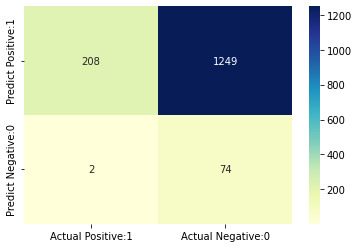

In [815]:
# Visualise confusion matrix with seaborn heatmap

cm_matrix=pd.DataFrame(data=cm,columns=['Actual Positive:1','Actual Negative:0'],index=['Predict Positive:1', 'Predict Negative:0'] )

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [816]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.14      0.25      1457
           1       0.06      0.97      0.11        76

    accuracy                           0.18      1533
   macro avg       0.52      0.56      0.18      1533
weighted avg       0.94      0.18      0.24      1533



In [817]:
# Print classification accuracy

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy =(TP+TN)/float(TP+TN+FP+FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.1840


In [818]:
# Print Classification Error

classification_error = (FP+FN)/float(TP+TN+FP+FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.8160


In [819]:
#Print Precision score
precision = TP/float(TP+FP)
print('Precision : {0:0.4f}'.format(precision))

Precision : 0.1428


In [820]:
#Print Recall
recall=TP/float(TP+FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.9905


In [821]:
#True positive Rate
TPR=TP/float(TP+FN)
print('True Positive Rate : {0:0.4f}'.format(TPR))

True Positive Rate : 0.9905


In [822]:
#False positive rate
FPR = FP/float(FP+TN)
print('False Positive Rate : {0:0.4f}'.format(FPR))

False Positive Rate : 0.9441


In [823]:
#Specificity
specificity = TN/(TN+FP)
print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.0559


### Calculate Class Probabilities

In [824]:
# Print the first 10 predicted probabilities of two classes- 0 and 1

Y_pred_prob = gnb.predict_proba(X_test)[0:10]
Y_pred_prob

array([[8.23908101e-14, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [3.81964160e-09, 9.99999996e-01],
       [6.57383207e-03, 9.93426168e-01],
       [1.00000000e+00, 0.00000000e+00],
       [1.76041759e-08, 9.99999982e-01],
       [1.20845123e-09, 9.99999999e-01],
       [2.08732890e-10, 1.00000000e+00],
       [4.88866792e-09, 9.99999995e-01],
       [5.91484231e-13, 1.00000000e+00]])

In [825]:
# Store the probabilities in dataframe
Y_pred_prob_df=pd.DataFrame(data=Y_pred_prob, columns =['Stroke','No Stroke'])
Y_pred_prob_df

,Stroke,No Stroke
0,8.239081e-14,1.000000
1,1.000000e+00,0.000000
2,3.819642e-09,1.000000
3,6.573832e-03,0.993426
4,1.000000e+00,0.000000
5,1.760418e-08,1.000000
6,1.208451e-09,1.000000
7,2.087329e-10,1.000000
8,4.888668e-09,1.000000
9,5.914842e-13,1.000000


In [826]:
# Print the first 10 predicted probabilities for class 1 - Probability of stroke
gnb.predict_proba(X_test)[0:10, 1]

array([1.        , 0.        , 1.        , 0.99342617, 0.        ,
       0.99999998, 1.        , 1.        , 1.        , 1.        ])

In [827]:
# Store the predicted probabilities for class 1 - Probability of stroke
Y_pred1 =gnb.predict_proba(X_test)[:,1]

Text(0, 0.5, 'Frequency')

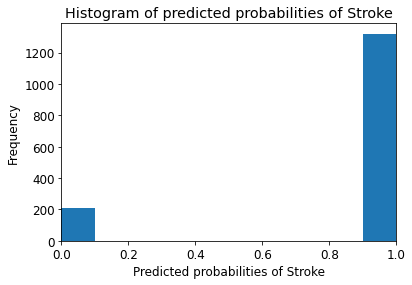

In [828]:
# Plot histogram of predicted probabilities

# adjust the font size
plt.rcParams['font.size'] = 12

# plot histogram with 10 bins
plt.hist(Y_pred1, bins = 10)

# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of Stroke')

# set the x-axis limit
plt.xlim(0,1)

# set the title
plt.xlabel('Predicted probabilities of Stroke')
plt.ylabel('Frequency')

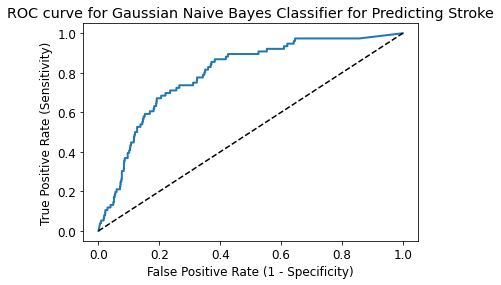

In [829]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred1)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Gaussian Naive Bayes Classifier for Predicting Stroke')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [830]:
# Compute ROC AUC
ROC_AUC =roc_auc_score(Y_test, Y_pred1)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7953


In [831]:
# Calculate cross-validated ROC AUC
Cross_validated_ROC_AUC = cross_val_score(gnb, X_train, Y_train, cv=5, scoring='roc_auc').mean()

print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8062


In [832]:
# Applying 10-Fold Cross Validation
scores = cross_val_score(gnb, X_train, Y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.22067039 0.2122905  0.20391061 0.18435754 0.17318436 0.14804469
 0.19273743 0.20168067 0.16526611 0.26890756]


In [833]:
# Compute Average cross-validation score

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.1971


In [18]:
#Split data into separate training and test and test set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.3, random_state=0)

In [19]:
#Check the shape of X_train and X_test
X_train.shape, X_test.shape

((3577, 10), (1533, 10))

###Feature Engineering